In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")

In [18]:
from tokenizers import Tokenizer
import sys

import matplotlib.pyplot as plt
import numpy as np
import collections
import torch

from ChEmbed.data import chembldb, smiles_dataset, chembed_tokenize
from ChEmbed.training import trainer
from ChEmbed.modules import simple_rnn
import attr

from ChEmbed import plots, utilities

from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [19]:
chembl_raw = chembldb.ChemblDB()
chembl_smiles = chembl_raw._load_or_download()["canonical_smiles"]

In [20]:
tokenizer = chembed_tokenize.load_chembed_tokenizer(filepath = "../data/tokenizers/tokenizer-chembldb-16-06-2025.json")

In [21]:
# chembl_dataset = smiles_dataset.SMILESDataset(
#     smiles_list = chembl_smiles,
#     tokenizer = tokenizer
# )

# chembl_mini = smiles_dataset.SMILESDataset(
#     smiles_list = chembl_smiles[:5000],
#     tokenizer = tokenizer
# )

In [56]:
chembl_mini = smiles_dataset.SMILESDatasetContinuous(
    smiles_list = chembl_smiles[:5000],
    tokenizer = tokenizer,
    length = 33,
)

In [57]:
chembl_mini[0]

(tensor([  4,   7, 477,   4,  33,  20,  24,   4,  33,   5,  33,   5,  87,   5,
         188,  24,   0,  62,   0,  58,  41,  24,  21,  28,  43,   4,  24,   5,
          41,  24,  21,  28]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [94]:
model = simple_rnn.simpleRNN(
    # Mandatory
    num_hiddens = 128,
    vocab_size = len(tokenizer),
    # tuning
    learning_rate = 0.5,
    weight_decay = 0.05
)

In [100]:
def predict(input, num_preds, model, dataset, device=None):
    outputs = [input[0]]
    
    index_outputs = []
    # predict input + num_preds tokens
    for i in range(len(input) + num_preds - 1):
        
        X = torch.tensor(dataset.encoding_to_one_hot(dataset.tokenizer.encode(''.join(outputs))), device=device)
        
        rnn_outputs = model(X)
        
        if i < len(input) - 1:
            outputs.append(input[i + 1])
        else:
            tokens = int(rnn_outputs[:, -1].argmax())
            index_outputs.append(tokens)
            Y = dataset.tokenizer.decode(tokens)
            outputs.append(Y)


    return ''.join(outputs), index_outputs
            

In [101]:
print(predict("C=O", 30, model, chembl_mini, device="cpu"))

/tmp/ipykernel_103994/2961657992.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encoding_to_one_hot(dataset.tokenizer.encode(''.join(outputs))), device=device)


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [102]:
model_trainer = trainer.Trainer(max_epochs=16, init_random=None, clip_grads_norm=3.0)
model_trainer.fit(model, chembl_mini)

Epoch 1/16: Train Loss: 6.6068, Val Loss: 3.6948
Epoch 2/16: Train Loss: 3.8261, Val Loss: 3.5938
Epoch 3/16: Train Loss: 4.1431, Val Loss: 3.6450
Epoch 4/16: Train Loss: 3.7183, Val Loss: 3.6634
Epoch 5/16: Train Loss: 3.6418, Val Loss: 3.6291
Epoch 6/16: Train Loss: 3.8321, Val Loss: 3.9036
Epoch 7/16: Train Loss: 4.3616, Val Loss: 5.6260
Epoch 8/16: Train Loss: 7.5256, Val Loss: 9.4803
Epoch 9/16: Train Loss: 10.1251, Val Loss: 14.9738
Epoch 10/16: Train Loss: 10.6424, Val Loss: 7.7691


KeyboardInterrupt: 

In [103]:
# print gradients of model
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.grad)

In [104]:
print(predict("C=O", 30, model, chembl_mini, device="cuda"))

('C=O[EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM][EOM]', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


/tmp/ipykernel_103994/2961657992.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(dataset.encoding_to_one_hot(dataset.tokenizer.encode(''.join(outputs))), device=device)


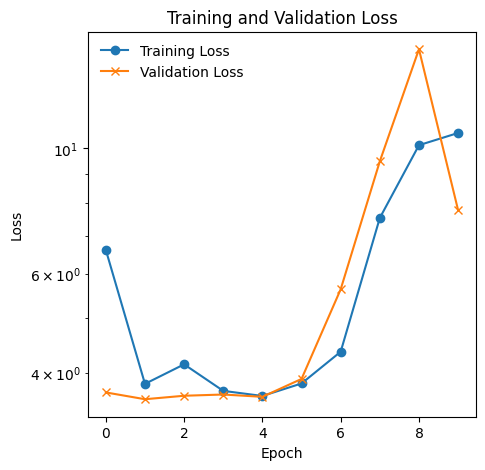

In [105]:
losses = utilities.extract_training_losses(model_trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale('log')

In [ ]:
encoded = chembl_mini.tokenizer.encode("C")
encoded_1h = chembl_mini.encoding_to_one_hot(encoded)
print(encoded)
print(encoded_1h.argmax())

[24]
tensor(24)


In [ ]:
pred_raw = model(encoded_1h)


In [ ]:
pred_raw.shape

torch.Size([1, 1029])

In [ ]:
tokens = pred_raw.argmax(1).tolist()

In [ ]:
print(chembl_mini.tokenizer.decode(tokens))

CN2CCN


In [ ]:
chembl_mini.tokenizer.decode(chembl_mini[0][0].argmax(1).tolist())

'Cc1cc ( - c2csc ( N = C ( N ) N ) n2 ) cn1 C [UNK] EOM [UNK] CC [ C @ H ] ( C ) [ C'

In [ ]:
chembl_mini.tokenizer.decode(chembl_mini[0][1].argmax(0).tolist())

'@'